In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import vigra
from vigra import graphs
import copy
import os
import pylab
import time
from scipy.io import loadmat
import sys

import inferno
import multicutAuxFunctions as maf

In [2]:
resultsPath = 'results/151119_fullTraining/'

# Training

In [3]:
trainSetPath = 'trainingSet/'
#trainSetPath = 'fewImages/'


path = os.walk(trainSetPath)

trainingIds = []
trainingImgs = []

gtLabels = []
gtSols = []

trainingRags = []

superpixelDiameter = 20      # super-pixel size
slicWeight         = 25.0    # SLIC color - spatial weight
beta               = 0.5     # node vs edge weight
nodeNumStop        = 50      # desired num. nodes in result
minSize            = 15

############# load images and convert to LAB #############
for root, dirs, files in path:
    jpgFiles = [filename for filename in files if filename.endswith('.jpg')]
    T = len(jpgFiles)
    for i, filename in enumerate(jpgFiles):
        
        sys.stdout.write('\r')
        sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
        sys.stdout.flush()

        fileId = filename[:-4]
        trainingIds.append(fileId)
        
        img = vigra.impex.readImage(root + '/' + filename)
        trainingImgs.append(img)
        imgLab = vigra.colors.transform_RGB2Lab(img)
            
        gridGraph = graphs.gridGraph(img.shape[0:2])

        slicLabels = vigra.analysis.labelImage(vigra.analysis.slicSuperpixels(imgLab, slicWeight, superpixelDiameter, minSize=minSize)[0])
        rag = graphs.regionAdjacencyGraph(gridGraph, slicLabels)
        trainingRags.append(rag)
        
        gtWatershed = loadmat('trainingSet/groundTruth/' + fileId + '.mat')['groundTruth'][0,0][0][0][0]
        gtLabel = maf.getSuperpixelLabelList(rag, gtWatershed)
        gtLabels.append(gtLabel)
                
        gtSols.append(maf.getGroundTruthSol(rag, gtLabel))

        

[==================================================] 100%

In [4]:
trainingFeatureSpaces = []
trainingEdges = []
t1 = time.time()
T = len(trainingImgs)
print "Building up Feature Space..."
sys.stdout.flush()
for i, (rag, img, trainId) in enumerate(zip(trainingRags, trainingImgs, trainingIds)):
    trainingEdges.append(rag.uvIds().astype('uint64'))
    
    if (os.path.isfile(resultsPath + 'featureSpaces/' + trainId + '.npy') == True):
        features = np.load(resultsPath + 'featureSpaces/' + trainId + '.npy')
        if (os.path.isfile(resultsPath + 'featureSpaces/featureNames.npy') == True):
            trainingFeatureNames = np.load(resultsPath + 'featureSpaces/featureNames.npy')
        
    else:
        features, trainingFeatureNames = maf.getFeatures(rag, img, trainId)
        np.save(resultsPath + 'featureSpaces/' + trainId + '.npy', features)
        np.save(resultsPath + 'featureSpaces/featureNames.npy', trainingFeatureNames)
        
    
    sys.stdout.write('\r')
    sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
    sys.stdout.flush()
    
    trainingFeatureSpaces.append(features)
t2 = time.time()

print "\nTime to built up Feature Space:", t2-t1, "sec"

Building up Feature Space...
[==================================================] 100%
Time to built up Feature Space: 0.333652019501 sec


In [6]:
subGradParameter = dict(maxIterations=300, nThreads=4, n=1.)
weightVector = maf.performLearning(trainingFeatureSpaces, trainingRags, trainingEdges, gtLabels,
                                   loss='partitionHamming', learnerParameter=subGradParameter, regularizerStr=1.)

np.save(resultsPath + 'partitionHamming/weights.npy', weightVector)

Begin weight learning...
Learning Duration:  1980.43713689 sec


In [15]:
RF = maf.buildRandomForest(trainingFeatureSpaces, gtSols, resultsPath + 'RF.hdf5')

In [16]:
trainingRfProbs = maf.getProbsFromRF(trainingFeatureSpaces, RF)

trainingFeatureSpaces[:] = [np.concatenate((featureSpace, prob), axis=1) for featureSpace, prob in zip(trainingFeatureSpaces, trainingRfProbs)]
trainingFeatureNames.extend(('RF_Prob1', 'RF_Prob2'))


In [17]:
# extend weight vector for random forest features

auxWeightVec = np.zeros(len(weightVector))
for w in range(len(weightVector)):
    auxWeightVec[w] = weightVector[w]
    
weightVector = inferno.learning.WeightVector(len(weightVector)+2, 0.0)
for w in range(auxWeightVec.shape[0]):
    weightVector[w] = auxWeightVec[w]

In [8]:
### load old weight vector

auxWeightVec = np.load(resultsPath + 'partitionHamming/weights.npy')

weightVector = inferno.learning.WeightVector(auxWeightVec.shape[0], 0.0)
for w in range(auxWeightVec.shape[0]):
    weightVector[w] = auxWeightVec[w]

In [9]:
StochGradParameter = dict(maxIterations=4, nPertubations=5, sigma=5., n=30.)
weightVector = maf.performLearning(trainingFeatureSpaces, trainingRags, trainingEdges, gtLabels,
                                   loss='variationOfInformation', learnerParameter=StochGradParameter, 
                                   regularizerStr=1., start=weightVector)

np.save(resultsPath + 'VOIwoRF/weights.npy', weightVector)

Begin weight learning...
Learning Duration:  13868.4265029 sec


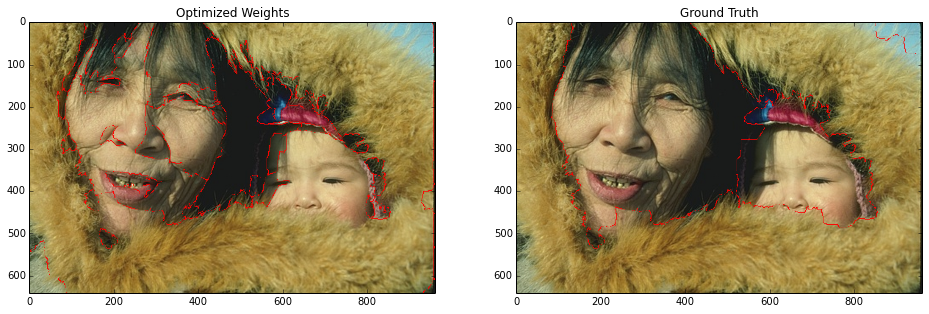

In [10]:
ParaMcModel = inferno.models.ParametrizedMulticutModel

nTrainSamples = len(trainingImgs)

modelVec = ParaMcModel.modelVector(nTrainSamples)

for n in range(nTrainSamples):

    nVar = trainingRags[n].nodeNum
    modelVec[n]._assign(nVar, trainingEdges[n]-1, trainingFeatureSpaces[n], weightVector) # -1 at edges so that nodes start at 0


############ Use Multicut on training image with given weightVector ###############
i = 1

if (i >= nTrainSamples or i < 0):
    print "i invalid! i was set to 0 for now!"
    i = 0

solver = inferno.inference.multicut(modelVec[i])

visitor = inferno.inference.verboseVisitor(modelVec[i])
#visitor = inferno.inference.visitor(modelVec[i])

solver.infer(visitor.visitor())    # bei .infer() gibt er was in konsole aus


conf = solver.conf()

arg = conf.view().astype('uint32')
arg = np.array([0] + list(arg), dtype=np.uint32) + 1

f = pylab.figure(figsize=(16,16))
ax0 = f.add_subplot(1,2,1)
trainingRags[i].show(trainingImgs[i], labels=arg, edgeColor=(1,0,0), alpha=0.)
ax0.set_title('Optimized Weights')

ax1 = f.add_subplot(1,2,2)
trainingRags[i].show(trainingImgs[i], labels=gtLabels[i], edgeColor=(1,0,0), alpha=0.)
ax1.set_title('Ground Truth')


pylab.show()

75
(1259, 75)


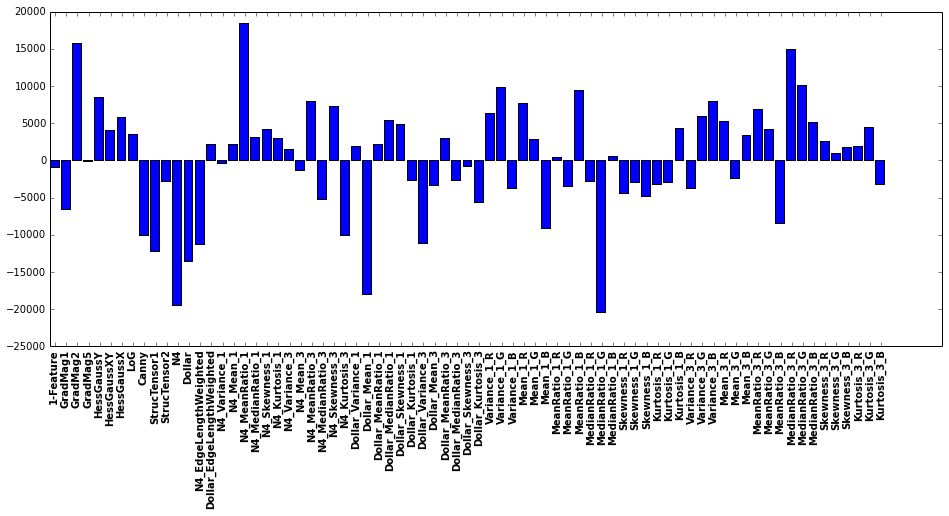

array([  -892.04582112,  -6471.4584023 ,  15773.28750483,   -135.43260335,
         8568.93106147,   4129.08972898,   5821.9599009 ,   3491.21280615,
        -9983.73004313, -12162.06162134,  -2724.66293874, -19489.18833561,
       -13461.85516306, -11196.35476623,   2249.92776816,   -367.96855069,
         2274.3745763 ,  18466.1380839 ,   3122.08686136,   4171.62974194,
         2968.7827806 ,   1583.10711411,  -1222.53640916,   7960.7389736 ,
        -5161.9284678 ,   7380.96242412,  -9994.93445674,   1915.15540723,
       -17950.71771865,   2163.13023457,   5485.88850767,   4911.79936841,
        -2625.65345819, -11050.2600478 ,  -3291.59340747,   3001.49447649,
        -2638.62321215,   -698.70148628,  -5624.36695551,   6348.23995281,
         9896.04481711,  -3696.48347027,   7665.45292248,   2935.00124579,
        -9025.91599828,    502.90395592,  -3472.92625572,   9469.62976966,
        -2772.09490075, -20392.5124941 ,    598.12148282,  -4362.9685506 ,
        -2858.00796227,  

In [15]:
print len(trainingFeatureNames)
print trainingFeatureSpaces[0].shape

auxWeightVec = np.zeros(len(weightVector))
for w in range(len(weightVector)):
    auxWeightVec[w] = weightVector[w]

f = plt.figure(figsize=(16,6))
ax = f.add_subplot(111)

ax.bar(range(auxWeightVec.shape[0]), auxWeightVec)
ax.set_xticks(np.linspace(0.5, len(trainingFeatureNames)-0.5, len(trainingFeatureNames)))
ax.set_xticklabels(trainingFeatureNames, rotation=90, weight=550)
plt.show()

auxWeightVec



# Testing

In [3]:
########### Use previous calculated weights ########################################
'''
### partition Hamming without edgeLengthWeighted N4/Dollar
weights = np.array([  7.22419899,   0.40247906,  -0.32125476,  -2.90153402,
    -0.51362044,   0.10224229,   0.2178948 ,   0.50556576,
    -2.55662064,   1.4081388 ,  -1.8826377 , -12.43351795,
    -10.56668765,  -0.11710111,  -0.29926287,  -1.29157775,
    0.71614733,   0.61672725,  -0.77740122,  -0.77069566,
     0.75244262,  -0.23765505,   1.63286551,   2.07582006,
    0.572415  ,  -0.04897844,  -0.07422355,  -1.07454004,
    -0.38744577,  -0.37478441,  -0.75440215])




weightVector = inferno.learning.WeightVector(weights.shape[0], 0.0)

for i in range(len(weightVector)):
    weightVector[i] = weights[i]
'''

-1

-1

In [11]:
########### Work with learned Random Forest and weights on Test Set #################

testSetPath = 'testSet/'

path = os.walk(testSetPath)

testImgs = []
testIds = []

testRags = []


superpixelDiameter = 20       # super-pixel size
slicWeight         = 25.0     # SLIC color - spatial weight
beta               = 0.5     # node vs edge weight
nodeNumStop        = 50         # desired num. nodes in result
minSize            = 15


############# load images and convert to LAB #############
T = len(os.listdir(testSetPath))
for root, dirs, files in path:
    for i, filename in enumerate(files):
        if (filename.endswith('.jpg')):
            
            sys.stdout.write('\r')
            sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
            sys.stdout.flush()

            fileId = filename[:-4]
            testIds.append(fileId)
            img = vigra.impex.readImage(root + filename)
            imgLab = vigra.colors.transform_RGB2Lab(img)
            testImgs.append(img)

            gridGraph = graphs.gridGraph(img.shape[0:2])

            slicLabels = vigra.analysis.labelImage(vigra.analysis.slicSuperpixels(imgLab, slicWeight, superpixelDiameter, minSize=minSize)[0])
            rag = graphs.regionAdjacencyGraph(gridGraph, slicLabels)
            testRags.append(rag)
            
            


[==================================================] 100%

In [12]:
testFeatureSpaces = []
testEdges = []

testingFeatureSpacesPath = resultsPath + 'featureSpaces/testing/'
if not os.path.exists(testingFeatureSpacesPath):
    os.makedirs(testingFeatureSpacesPath)

print "Building up Feature Space..."
T = len(testImgs)
for i, (rag, img, testId) in enumerate(zip(testRags, testImgs, testIds)):
    testEdges.append(rag.uvIds().astype('uint64'))

    if (os.path.isfile(testingFeatureSpacesPath + testId + '.npy') == True):
        features = np.load(testingFeatureSpacesPath + testId + '.npy')
        
    else:
        features = maf.getFeatures(rag, img, testId)[0]
        np.save(testingFeatureSpacesPath + testId + '.npy', features)


    sys.stdout.write('\r')
    sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
    sys.stdout.flush()

    testFeatureSpaces.append(features)

Building up Feature Space...
[==================================================] 100%

In [21]:
probs = maf.getProbsFromRF(testFeatureSpaces, RF)

testFeatureSpaces[:] = [np.concatenate((featureSpace, prob), axis=1) for featureSpace, prob in zip(testFeatureSpaces, probs)]

In [13]:
### build model

ParaMcModel = inferno.models.ParametrizedMulticutModel

nTestSamples = len(testImgs)
nFeatures = testFeatureSpaces[0].shape[1]

modelVec = ParaMcModel.modelVector(nTestSamples)

for n in range(nTestSamples):
    nVar = testRags[n].nodeNum
    modelVec[n]._assign(nVar, testEdges[n]-1, testFeatureSpaces[n], weightVector)


/usr/lib/pymodules/python2.7/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


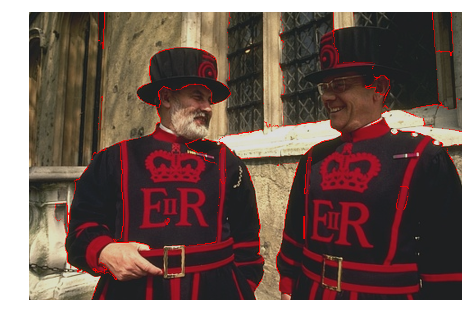

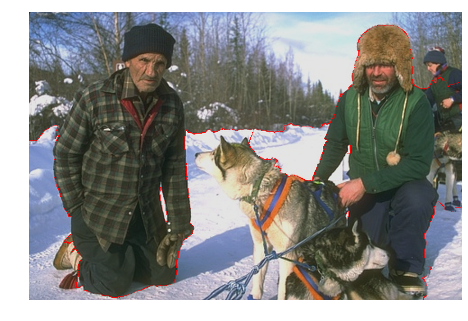

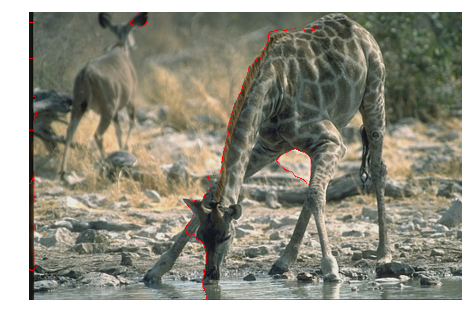

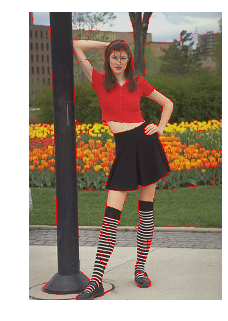

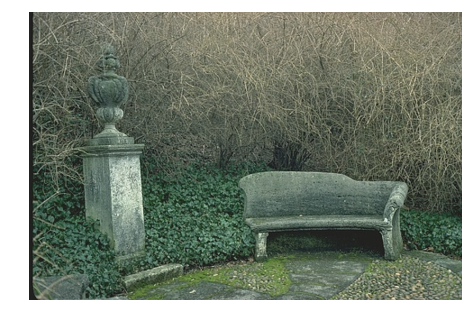

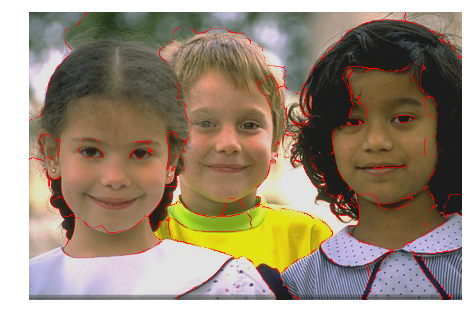

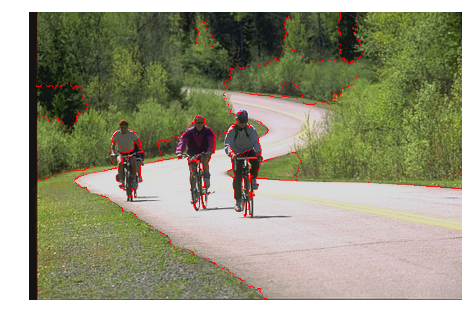

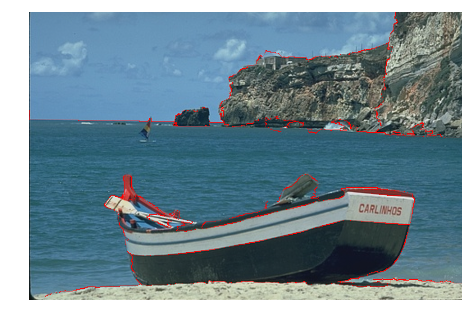

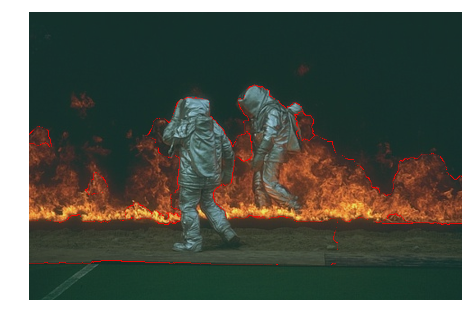

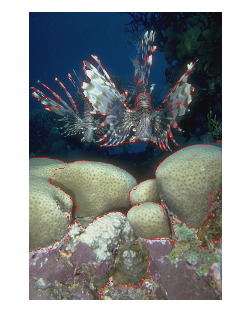

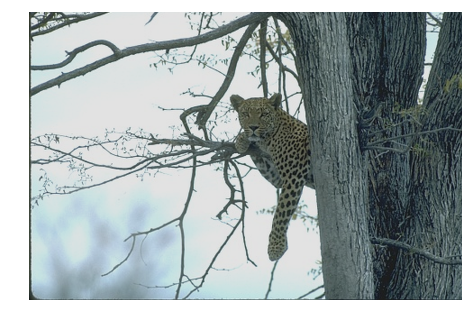

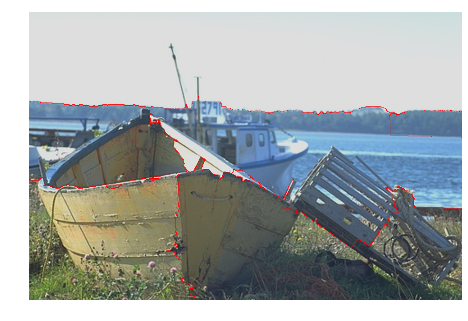

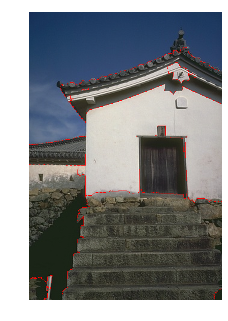

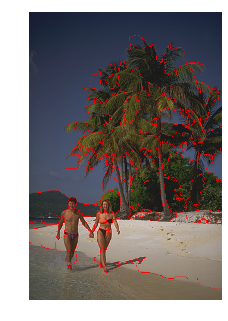

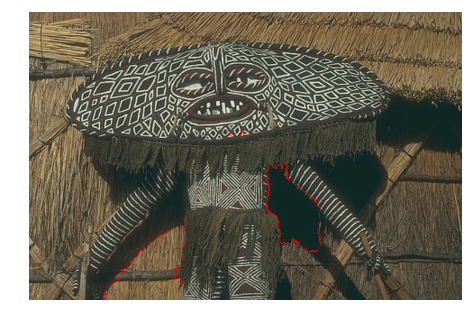

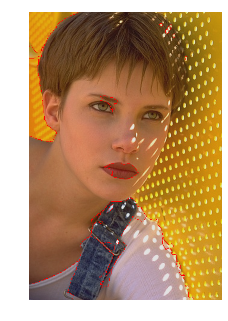

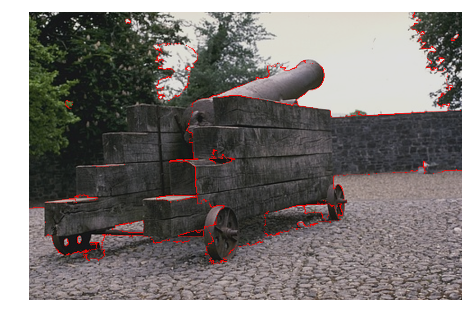

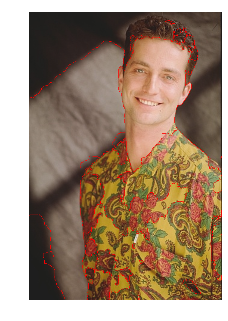

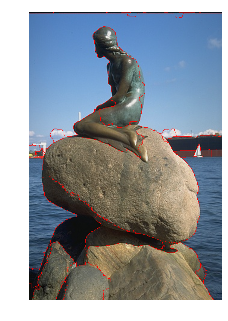

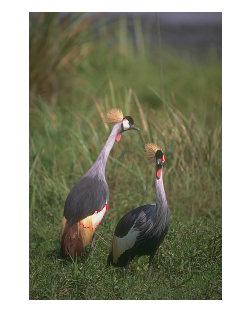

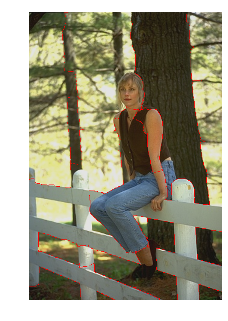

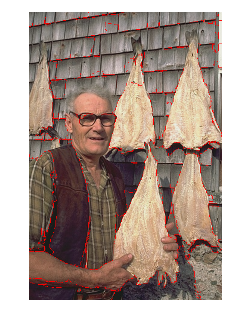

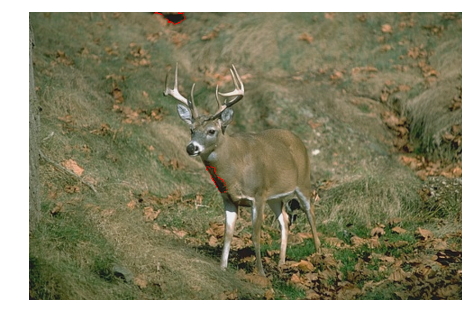

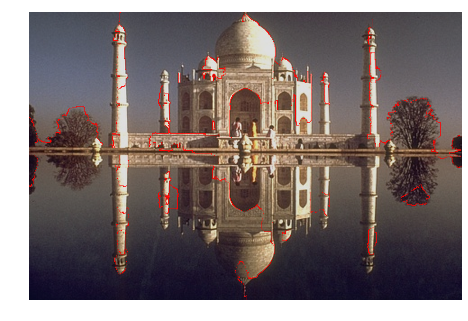

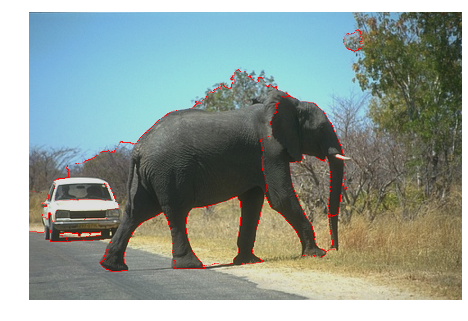

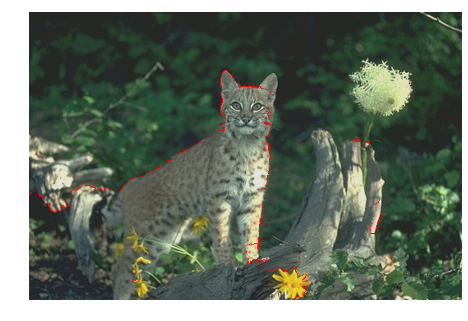

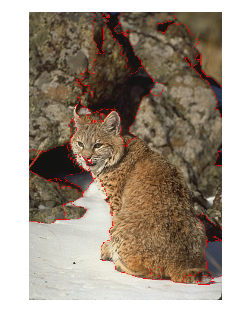

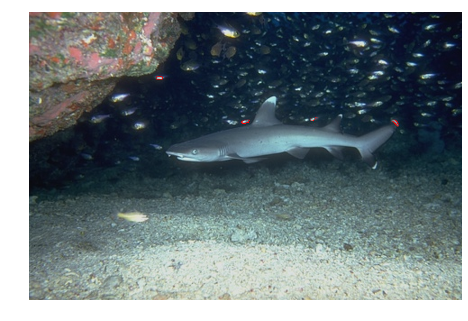

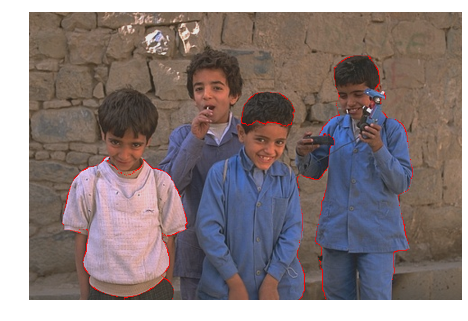

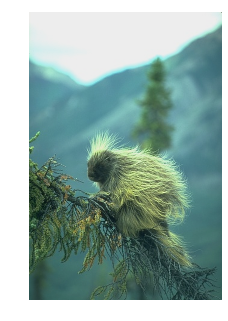

In [14]:
### solve


for i in range(30):
    #i = 4
    if (i >= nTestSamples):
        print " i ungueltig!!!"
        sys.stdout.flush()
        i = 0

    solver = inferno.inference.multicut(modelVec[i])

    visitor = inferno.inference.verboseVisitor(modelVec[i])
    solver.infer(visitor.visitor())

    conf = solver.conf()

    arg = conf.view().astype('uint32')
    arg = np.array([0] + list(arg), dtype=np.uint32) + 1

    fig = pylab.figure(frameon=False)
    
    # make figure without frame
    ax = pylab.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    testRags[i].show(testImgs[i], labels=arg, edgeColor=(1,0,0), alpha=0.)

    fig.savefig(resultsPath + 'VOIwoRF/' + str(testIds[i]) + '.tif', dpi=150)
    
    
    del fig, ax

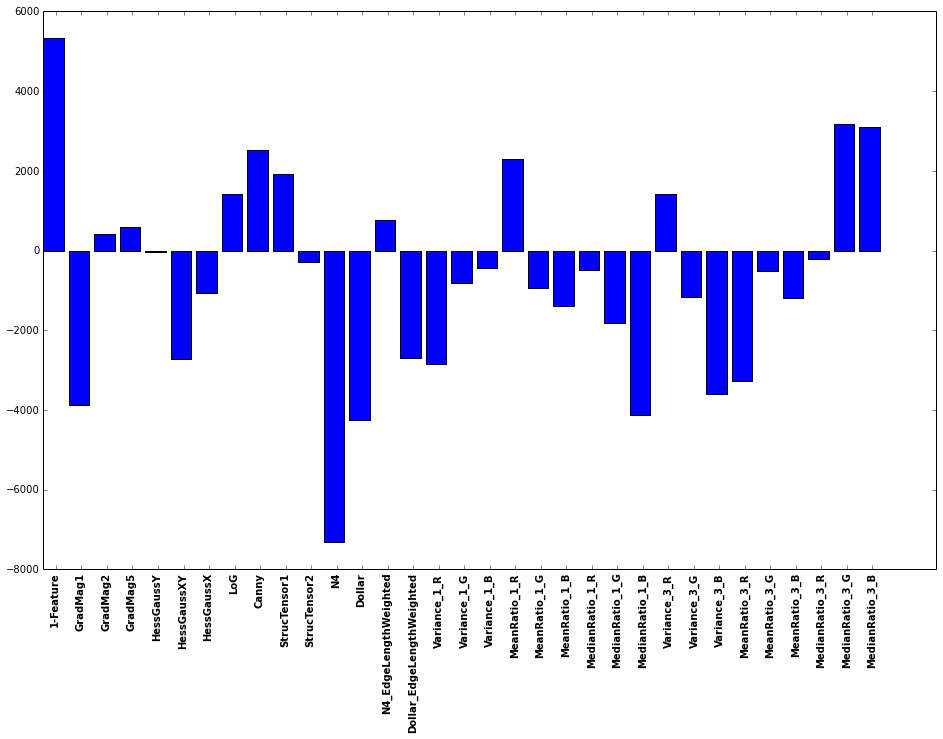

In [30]:
f = pylab.figure(figsize=(16,10))
ax1 = f.add_subplot(111)
ax1.bar(range(auxWeightVec.shape[0]), auxWeightVec)
ax1.set_xticks(np.linspace(0.5, len(trainingFeatureNames)-0.5, len(trainingFeatureNames)))
ax1.set_xticklabels(trainingFeatureNames, rotation=90, weight=550)

f.savefig('results/variationOfInformation/151112_hammingStart/weights.png')

In [43]:
a = np.array(['a', 'b'])

np.where(a=='a')

(array([0]),)

1

In [3]:
rag = trainingRags[0]
img = trainingImgs[0]


#a = maf.getEdgeWeightsFromNodesAround2(rag, img, 1, variance=True, meanRatio=True, medianRatio=True)
b = maf.getEdgeWeightsFromNodesAround3(rag, img, 1, variance=True, mean=True, meanRatio=True, medianRatio=True, 
                                                    skewness=True, kurtosis=True)




In [4]:
import inferno

weightConstraints = inferno.learning.WeightConstraints(3)

weightConstraints.addBound(0, 0.9, 1.1)

In [1]:
import numpy as np

In [39]:
print trainingFeatureSpaces[1].shape
print testFeatureSpaces[0].shape

(1089, 77)
(1778, 75)


In [20]:
np.save(resultsPath + 'featureSpaces/featureNames.npy', trainingFeatureNames)

In [12]:
for fs in training
np.save('results/151118_newStatsFeatures/featureSpaceWRF.npy', )

0.19198790627362072